In [74]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))

from src.utils.option_metrics import OptionMetricsFetcher
from src.engine.rbergomi import RBergomiEngine
from src.engine.calibrator import RBergomiCalibrator
from src.pricing.pricer import MonteCarloPricer

def extract_xi_variance_swap(df_slice):
    S0 = df_slice["stock_price"].iloc[0]
    T = df_slice["years_to_maturity"].iloc[0]
    r = df_slice["risk_free_rate"].iloc[0]
    df = df_slice.sort_values('strike').copy()
    F = S0 * np.exp(r * T)
    
    df['price'] = (df['best_bid'] + df['best_offer']) / 2
    
    
    term_list = []
    strikes = df['strike'].values
    prices = df['mid_price'].values
    
    for i in range(1, len(strikes)-1):
        dK = (strikes[i+1] - strikes[i-1]) / 2.0
        K = strikes[i]
        Q = prices[i]
        
        contribution = (dK / (K**2)) * np.exp(r*T) * Q
        term_list.append(contribution)
        
    sigma_squared = (2 / T) * sum(term_list)
    
    return sigma_squared

def extract_xi_atm(df_slice):
    S0 = df_slice["stock_price"].iloc[0]
    T = df_slice["years_to_maturity"].iloc[0]
    r = df_slice["risk_free_rate"].iloc[0]
    F = S0 * np.exp(r * T)
    
    df_slice = df_slice.copy()
    df_slice['dist_to_forward'] = abs(df_slice['strike'] - F)
    
    atm_option = df_slice.sort_values('dist_to_forward').iloc[0]
    
    sigma_atm = atm_option['impl_volatility']
    
    if pd.isna(sigma_atm) or sigma_atm <= 0:
        raise ValueError(f"Volatilité ATM invalide pour Strike={atm_option['strike']}: {sigma_atm}")

    xi_estime = sigma_atm ** 2
    
    info = {"xi_estime" : xi_estime,
        'forward_price': F,
        'atm_strike_found': atm_option['strike'],
        'atm_vol': sigma_atm,
        'distance_rel': atm_option['dist_to_forward'] / F, 
        'cp_flag': atm_option['cp_flag']
    }
    
    return xi_estime, info

om = OptionMetricsFetcher()

TICKER = 'SPX'
START = '2025-01-01'
END = '2025-01-31'

df_result = om.fetch_data(TICKER, START, END)

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [162]:
from src.utils.cleaning import clean_and_filter_options, get_calibration_snapshot
df_clean = clean_and_filter_options(df_result)

calib_slice, T_exact, S0, r = get_calibration_snapshot(df_clean, '2025-01-03', 3/12)

print(f"\n--- (S0={S0}, T={T_exact:.4f}) ---")
calib_slice.sort_values("moneyness", ascending=False, inplace=True)
calib_slice


--- (S0=5942.47, T=0.2384) ---


,date,exdate,stock_price,strike,cp_flag,moneyness,mid_price,best_bid,best_offer,risk_free_rate,impl_volatility,delta,gamma,vega,theta,days_to_maturity,years_to_maturity,volume,open_interest
46094,2025-01-03,2025-03-31,5942.47,4610.0,P,1.289039,10.85,10.7,11.0,0.048428,0.299454,-0.030515,0.000079,200.1273,-118.2414,87,0.238356,12.0,13.0
46096,2025-01-03,2025-03-31,5942.47,4625.0,P,1.284858,11.0,10.9,11.1,0.048428,0.297073,-0.031111,0.000081,203.3533,-119.1096,87,0.238356,12.0,296.0
46097,2025-01-03,2025-03-31,5942.47,4630.0,P,1.283471,11.05,10.9,11.2,0.048428,0.296278,-0.031311,0.000082,204.4361,-119.3949,87,0.238356,10.0,89.0
46099,2025-01-03,2025-03-31,5942.47,4650.0,P,1.277951,11.4,11.3,11.5,0.048428,0.293797,-0.032423,0.000085,210.4143,-121.7453,87,0.238356,503.0,160.0
46101,2025-01-03,2025-03-31,5942.47,4670.0,P,1.272478,11.65,11.5,11.8,0.048428,0.290799,-0.033353,0.000088,215.3779,-123.2262,87,0.238356,10.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45978,2025-01-03,2025-03-31,5942.47,6550.0,C,0.907247,4.7,4.6,4.8,0.048428,0.101876,0.040081,0.000292,250.3057,-62.38778,87,0.238356,4499.0,1017.0
45981,2025-01-03,2025-03-31,5942.47,6575.0,C,0.903798,3.9,3.8,4.0,0.048428,0.101966,0.034026,0.000255,218.9433,-54.38686,87,0.238356,7.0,4802.0
45984,2025-01-03,2025-03-31,5942.47,6600.0,C,0.900374,3.3,3.2,3.4,0.048428,0.102445,0.029263,0.000224,193.2908,-48.03942,87,0.238356,11.0,571.0
45996,2025-01-03,2025-03-31,5942.47,6700.0,C,0.886936,1.775,1.7,1.85,0.048428,0.10525,0.01648,0.000134,119.067,-29.95351,87,0.238356,1095.0,297.0


In [163]:
# xi_estime, info = extract_xi_atm(calib_slice)
# info
xi_estime = extract_xi_variance_swap(calib_slice) + 0.002
xi_estime

np.float64(0.02651112644368775)

In [164]:
engine = RBergomiEngine(
    S_0=S0,
    T=T_exact,
    N=500,
    r=r,
    xi_0=xi_estime,
    H=0.07,
    rho=-0.7,
    eta=1.9  
)

pricer = MonteCarloPricer(engine)

In [165]:
calib_data_dict = {
    'market_strike': calib_slice['strike'],
    'ivs': calib_slice['impl_volatility'],
    'option_type': calib_slice['cp_flag']
}

turbo_calibrator = RBergomiCalibrator(engine, pricer, calib_data_dict, n_paths=2000)

initial_guess = [-0.8, 2.2]

print("Starting Calibration with L-BFGS-B...")
opt_params = turbo_calibrator.calibrate(initial_guess=initial_guess)

if opt_params is not None:
    rho_opt, eta_opt = opt_params
    print(f"\n RESULTS :")
    print(f"Rho (Skew) : {rho_opt:.4f}")
    print(f"Eta (Vol-of-Vol) : {eta_opt:.4f}")
    print(f"Xi (Fixed) : {xi_estime:.6f}")
else:
    print("Calibration Failed.")

Calibrator initialized with 110 options (36 Calls, 74 Puts).
Starting Calibration with L-BFGS-B...
Starting calibration (n_paths=2000)...
 >> Step: rho=-0.8000 | eta=2.2000 | RMSE=0.00767
 >> Step: rho=-0.8000 | eta=2.2000 | RMSE=0.00767
 >> Step: rho=-0.8000 | eta=2.2000 | RMSE=0.00767
 >> Step: rho=-0.8268 | eta=2.2132 | RMSE=0.00684
 >> Step: rho=-0.8268 | eta=2.2132 | RMSE=0.00684
 >> Step: rho=-0.8268 | eta=2.2132 | RMSE=0.00684
 >> Step: rho=-0.9760 | eta=2.3732 | RMSE=0.00735
 >> Step: rho=-0.9760 | eta=2.3732 | RMSE=0.00735
 >> Step: rho=-0.9760 | eta=2.3732 | RMSE=0.00735
 >> Step: rho=-0.8993 | eta=2.2910 | RMSE=0.00527
 >> Step: rho=-0.8993 | eta=2.2910 | RMSE=0.00527
 >> Step: rho=-0.8993 | eta=2.2910 | RMSE=0.00527
 >> Step: rho=-0.8988 | eta=2.3408 | RMSE=0.00476
 >> Step: rho=-0.8988 | eta=2.3408 | RMSE=0.00476
 >> Step: rho=-0.8988 | eta=2.3408 | RMSE=0.00476
 >> Step: rho=-0.8966 | eta=2.5402 | RMSE=0.00324
 >> Step: rho=-0.8966 | eta=2.5402 | RMSE=0.00324
 >> Step: rh

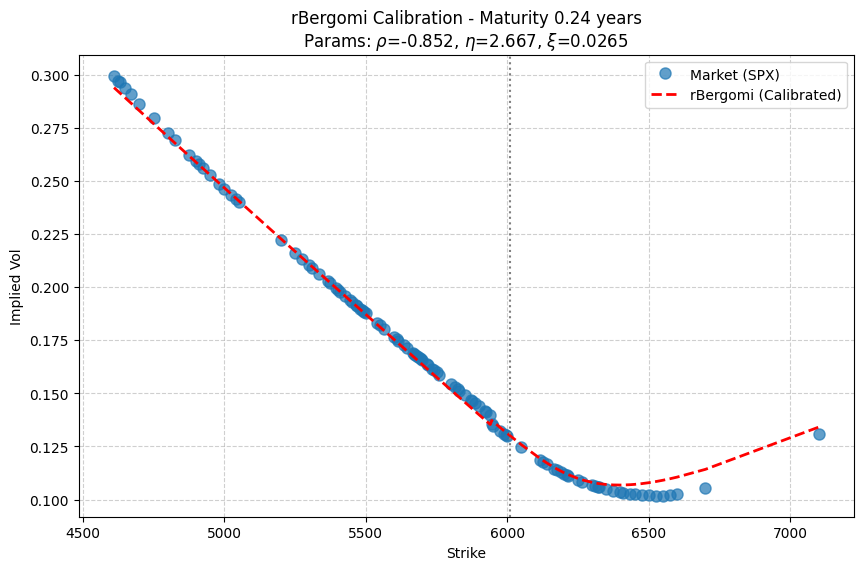

In [166]:
final_ivs_model = []

strikes = calib_slice['strike'].values
types = calib_slice['cp_flag'].values
mkt_ivs = calib_slice['impl_volatility'].values

model_ivs_res = np.zeros_like(mkt_ivs)

mask_c = (types == 'call') | (types == 'C')
if np.any(mask_c):
    _, _, ivs_c = pricer.price_european_option_turbo(
        K=strikes[mask_c], n_paths=5000, option_type='call', return_iv=True 
    )
    model_ivs_res[mask_c] = ivs_c

mask_p = (types == 'put') | (types == 'P')
if np.any(mask_p):
    _, _, ivs_p = pricer.price_european_option_turbo(
        K=strikes[mask_p], n_paths=5000, option_type='put', return_iv=True
    )
    model_ivs_res[mask_p] = ivs_p

# --- PLOT ---
plt.figure(figsize=(10, 6))
plt.plot(strikes, mkt_ivs, 'o', label='Market (SPX)', markersize=8, alpha=0.7)
plt.plot(strikes, model_ivs_res, '--', label=f'rBergomi (Calibrated)', linewidth=2, color='red')

plt.title(f"rBergomi Calibration - Maturity {T_exact:.2f} years\n"
          f"Params: $\\rho$={rho_opt:.3f}, $\\eta$={eta_opt:.3f}, $\\xi$={xi_estime:.4f}")
plt.xlabel("Strike")
plt.ylabel("Implied Vol")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.axvline(x=S0 * np.exp(r * T_exact), color='gray', linestyle=':', label='Forward Price')

plt.show()
